<a href="https://colab.research.google.com/github/opi-lab/stsiva-workshop/blob/main/notebooks/stsiva_workshop_notebook03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Light 3D reconstruction

*STSIVA Workshop - 2021*

**Speakers:**    
Jhacson Meza - [@jhacsonmeza](https://github.com/jhacsonmeza)    
Andrés G. Marrugo, PhD -     [@agmarrugo](https://github.com/agmarrugo)     
Universidad Tecnológica de Bolívar    

In this example, we will estimate the 3D reconstruction of an object based on stereo triangulation. We have a camera-projector setup where we project patterns to establish correspondences between both devices for triangulation.

*The source of this notebook is located at https://github.com/opi-lab/stsiva-workshop/*

*Useful intro about [Colab](https://colab.research.google.com/notebooks/welcome.ipynb)*

*Useful intro about [OpenCV](https://opencv.org/)*

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import glob
import cv2

We need first the dataset of images for calibration. We will store all the image filenames in the list.

In [2]:
imlist = sorted(glob.glob('/content/images/*'))

Load camera-projector calibration parameters:

In [3]:
params = np.load('cam_proj_param.npz')

K1 = params['K1']
K2 = params['K2']
dist1 = params['dist1']
dist2 = params['dist2']

R = params['R']
t = params['t']

Phase shifting step and fringe period

In [4]:
N = 18
p = 18

Read image with texture and mask

In [5]:
im = cv2.imread(imlist[-1], 0)
mask = cv2.imread('/content/mask.png', 0)

This is the object we want to reconstruct with the structured light technique.

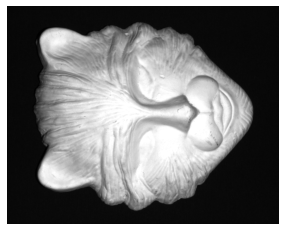

In [6]:
plt.figure()
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

## Aboluste phase maps estimation

We have a list of filename images in `imlist`. In that list we have fringe images and graycoding patterns

In [7]:
imlist_ps = imlist[:2*N] # List of images for phase shifting
imlist_gc = imlist[2*N:-1] # List of images for for graycoding

When using graycoding, we different binary patterns for $x$ and $y$ projection direction. This amout can be estimated based on the projector image dimension (which is $1280\times800$)

In [8]:
# Number of vertical and horizontal graycoding patterns
nv = 2*int(np.ceil(np.log2(1280/p)))
nh = 2*int(np.ceil(np.log2(800/p)))

For absolute phase estimation we use the phase-shifting + graycoding temporal phase unwrapping mehtod. The function for unwrapping is available on the [repository]()https://github.com/opi-lab/stsiva-workshop/blob/main/modules/ps_gc.py) of the workshop. For this example, we will just import the needed function by dowloading this file.

In [9]:
!wget https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/modules/ps_gc.py

--2021-09-17 07:06:31--  https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/modules/ps_gc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495 (1.5K) [text/plain]
Saving to: ‘ps_gc.py’

ps_gc.py            100%[===================>]   1.46K  --.-KB/s    in 0s      

2021-09-17 07:06:31 (29.1 MB/s) - ‘ps_gc.py’ saved [1495/1495]



Vertical absolute phase map estimation $\Phi_x$.

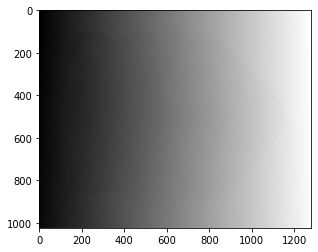

In [10]:
import ps_gc

# Estimate absolute phase in x using phase shifting + graycoding method
Phix = ps_gc.phaseGraycodingUnwrap(imlist_ps[:N], imlist_gc[:nv], p, N)

plt.figure()
plt.imshow(Phix, cmap='gray')
plt.show()

Horizontal absolute phase map estimation $\Phi_y$.

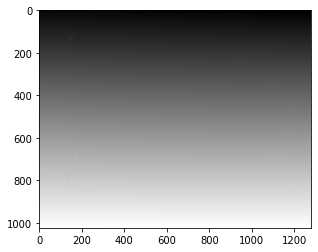

In [11]:
# Estimate absolute phase in y using phase shifting + graycoding method
Phiy = ps_gc.phaseGraycodingUnwrap(imlist_ps[N:], imlist_gc[nv:nv+nh], p, N)

plt.figure()
plt.imshow(Phiy, cmap='gray')
plt.show()

## Establish camera projector correspondences

with the estimated absolute phase maps, we can convert the phase values to pixel values on the projector image. For that, we first need the camera coordinates. We just consider the points into the mask.

In [12]:
# Camera 2D coordinates
yc, xc = np.where(mask)

Based on the expresions:
$$
u^p = \dfrac{p}{2\pi} \Phi_x(u^c, v^c) \enspace, \\
v^p = \dfrac{p}{2\pi} \Phi_y(u^c, v^c) \enspace,
$$

for a camera point $(u^c, v^c)$ we can estimate the $(u^p, v^p)$ corresponding projector point, where $p$ is the period or pitch of the fringes (stored in the variable `p`).

In [13]:
# Projector 2D coordinates
xp = p/(2*np.pi)*Phix[yc,xc]
yp = p/(2*np.pi)*Phiy[yc,xc]

For 3D reconstruction is important to compensate for lens distortion both camera and projector points to obtain low reconstruction errors.

In [14]:
# Converting the coordinates to (n, 1, 2) arrays
ptsc = np.c_[xc,yc].reshape(-1,1,2).astype(np.float)
ptsp = np.c_[xp,yp].reshape(-1,1,2)

# Points undistortion with OpenCV
ptscu = cv2.undistortPoints(ptsc, K1, dist1, None, None, K1)
ptspu = cv2.undistortPoints(ptsp, K2, dist2, None, None, K2)

## 3D reconstruction

Once matches are established and the distortion is removed for the correspondences, we can solve the structure of the object. We will use stereo triangulation with the OpenCV's function `triangulatePoints`. But first, we need to establish the projection matrices for camera and projector:

In [15]:
# Build projection matrices
P1 = K1 @ np.c_[np.eye(3), np.zeros(3)]
P2 = K2 @ np.c_[R, t]

Now, we can reconstruct the object

In [16]:
# Triangulate (DLT method)
X = cv2.triangulatePoints(P1, P2, ptscu, ptspu)
X = X[:3]/X[-1] # From homogeneous to Euclidean

For 3D visualization we need first the colors of each 3D point, which correspond to the grayscale values of each camera pixel.

In [17]:
C = im[yc,xc]

Using `matplotlib` for 3D visualization:

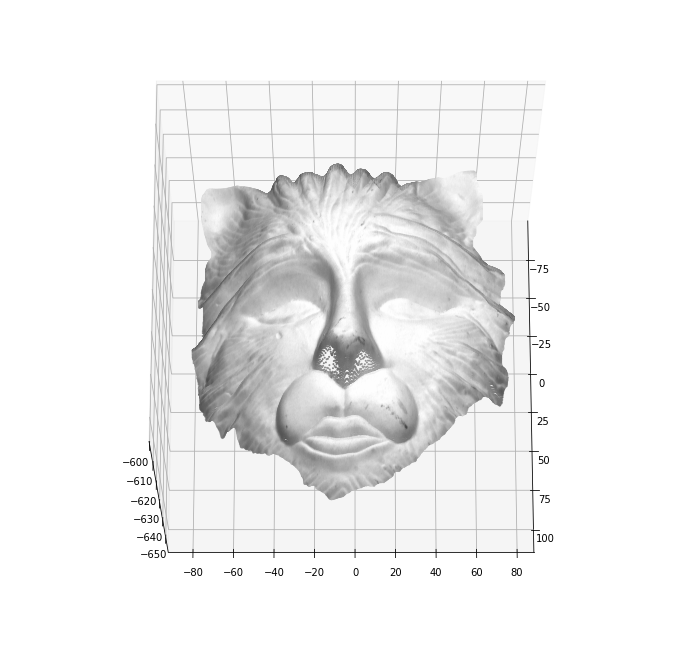

In [18]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.view_init(70, 0) # Point of view for a better visualization
ax.scatter(X[0], X[1], -X[2], c=np.stack(3*[C], 1)/255.0, s=1)
plt.show()